In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import time
import os
import ldspec
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statsmodels.stats.multitest import multipletests
from matplotlib import gridspec
import seaborn as sns
import statsmodels.formula.api as smf

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
DATA_PATH = '/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp'
FIG_PATH = '/n/groups/price/martin/LDSPEC_data/results/fig_res'
TAB_PATH = '/n/groups/price/martin/LDSPEC_data/results/tables'

# DF_TRAIT, DF_ANNOT, DF_PANNOT
DF_TRAIT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/trait_info.tsv', sep='\t')
DF_TRAIT.index = DF_TRAIT['Trait_Identifier']
TRAIT_LIST = list(DF_TRAIT.index)
TRAIT_LIST_INDPT = list(DF_TRAIT.index[DF_TRAIT['Indpt']])
print("n_trait=%d" % len(TRAIT_LIST))
print("n_trait_indpt=%d" % len(TRAIT_LIST_INDPT))

DF_ANNOT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/annot_info.tsv', sep='\t')
DF_ANNOT.index = DF_ANNOT['Identifier']
print("n_annot=%d" % DF_ANNOT.shape[0])

DF_PANNOT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/pannot_info.tsv', sep='\t')
DF_PANNOT.index = DF_PANNOT['Identifier']
print("n_pannot=%d" % DF_PANNOT.shape[0])

# Others
temp_df = pd.read_csv('../names.tsv', sep='\t', header=None)
DIC_NAME = {x:y for x,y in zip(temp_df[0], temp_df[1])}
DIC_COLOR = {'common_common' : '#78ADD2', 'common' : '#78ADD2', 'common_lf' : '#80C680',
             'lf_lf' : '#FFB26E', 'lf' : '#FFB26E'}
MARKER_LIST=['o', 'v', '^', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', '<', '>']

n_trait=70
n_trait_indpt=29
n_annot=45
n_pannot=34


### Load results and meta-analysis

In [3]:
# Load results 
DIC_RES_PATH = {
    'md_prox_gene_fct_all_ld' : DATA_PATH + '/ldspec_res_092223.prox_gene_fct_all_ld/@t',
}

# Load .pickle files: dic_res[md][trait] = .pickle
dic_res = {}
missing_list = []
for md in DIC_RES_PATH:
    dic_res[md] = {}   
    temp_list = TRAIT_LIST if md=='md_prox_gene_fct_all_ld' else TRAIT_LIST_INDPT
    for i,trait in enumerate(temp_list):
        if os.path.exists(DIC_RES_PATH[md].replace("@t", trait) + ".pickle"):
            with open(DIC_RES_PATH[md].replace("@t", trait) + ".pickle", "br") as f:
                dic_res[md][trait] = pickle.load(f)
            # Check avgr
            with open(DIC_RES_PATH[md].replace("@t", trait) + ".sbatch.log", "r") as f:
                for line in f:
                    if 'Detected AVGR for' in line:
                        line = line.strip()
                        n1,n2 = line.split(' ')[3].split('/')
                        if n1!=n2: 
                            print("Missing AVGR: %-20s %-35s %s %s" % (md, trait, i+1, line))
        else:
            print("Missing %-10s %-30s %s" % (md, trait, i+1))
            if trait not in missing_list: 
                missing_list.append(trait)

In [4]:
# Load LD-SPEC meta-analysis results 
df_tau = pd.read_csv(TAB_PATH + '/ldspec.md_prox_gene_fct_all_ld.tau.tsv', sep='\t')
df_tau.index = ['%s.%s' % (x,y) for x,y in zip(df_tau['trait'], df_tau['annot'])]
df_omega = pd.read_csv(TAB_PATH + '/ldspec.md_prox_gene_fct_all_ld.omega.tsv', sep='\t')
df_omega.index = ['%s.%s' % (x,y) for x,y in zip(df_omega['trait'], df_omega['pannot'])]
df_tau_meta = pd.read_csv(TAB_PATH + '/ldspec_meta.md_prox_gene_fct_all_ld.tau.tsv', sep='\t', index_col=0)
df_omega_meta = pd.read_csv(TAB_PATH + '/ldspec_meta.md_prox_gene_fct_all_ld.omega.tsv', sep='\t', index_col=0)

### Individual trait results 

In [5]:
df_stats = pd.DataFrame(index=TRAIT_LIST, dtype=float)
pAN_list = list(set(df_omega['pannot']))
print('n_trait=%d, n_pAN=%d' % (df_stats.shape[0], len(pAN_list)))

for pAN in pAN_list:
    df_stats[pAN] = [df_omega.loc['%s.%s'%(x,pAN), 'cor'] for x in df_stats.index]
    df_stats['%s_se'%pAN] = [df_omega.loc['%s.%s'%(x,pAN), 'cor_se'] for x in df_stats.index]
    df_stats['%s_p'%pAN] = [df_omega.loc['%s.%s'%(x,pAN), 'cor_p'] for x in df_stats.index]
    df_stats['%s_fwer'%pAN] = df_stats['%s_p'%pAN] * len(pAN_list)
    df_stats['%s_sig_str'%pAN] = ['*' if x<0.05 else '' for x in df_stats['%s_fwer'%pAN]]
    
print('n_sig_fwer=%d' % (df_stats[['%s_sig_str'%x for x in pAN_list]]=='*').sum().sum())
print('n_sig_trait_fwer=%d' % ((df_stats[['%s_sig_str'%x for x in pAN_list]]=='*').sum(axis=1)>0).sum())
print('n_sig_annot_fwer=%d' % ((df_stats[['%s_sig_str'%x for x in pAN_list]]=='*').sum(axis=0)>0).sum())

for trait in TRAIT_LIST:
    for pAN in [x for x in pAN_list if 'ld_p0_p100' in x]:
        if df_stats.loc[trait, '%s_fwer'%pAN] < 0.05:
            print('%-30s %-20s\n        cor=%.3f se=%.3f p=%.3e fwer=%.3e' % (
                DF_TRAIT.loc[trait, 'Trait Name'], DIC_NAME[pAN],
                df_stats.loc[trait, pAN], 
                df_stats.loc[trait, '%s_se'%pAN],
                df_stats.loc[trait, '%s_p'%pAN],
                df_stats.loc[trait, '%s_fwer'%pAN],
            ))
print('')
for trait in TRAIT_LIST:
    for pAN in [x for x in pAN_list if 'ld_n100_p0' in x]:
        if df_stats.loc[trait, '%s_fwer'%pAN] < 0.05:
            print('%-30s %-20s\n        cor=%.3f se=%.3f p=%.3e fwer=%.3e' % (
                DF_TRAIT.loc[trait, 'Trait Name'], DIC_NAME[pAN],
                df_stats.loc[trait, pAN], 
                df_stats.loc[trait, '%s_se'%pAN],
                df_stats.loc[trait, '%s_p'%pAN],
                df_stats.loc[trait, '%s_fwer'%pAN],
            ))

n_trait=70, n_pAN=136
n_sig_fwer=12
n_sig_trait_fwer=10
n_sig_annot_fwer=9
Gamma Glutamyl Transferase     Transcribed-1k (low-freq pos-LD)
        cor=-1.162 se=0.254 p=3.609e-04 fwer=4.908e-02
SHBG                           Transcribed-1k (low-freq pos-LD)
        cor=-0.835 se=0.245 p=1.962e-04 fwer=2.669e-02
Monocyte Count                 H3K4me3-1k (common pos-LD)
        cor=-0.186 se=0.051 p=1.324e-04 fwer=1.800e-02
Height                         Transcribed-1k (low-freq pos-LD)
        cor=-0.524 se=0.116 p=3.049e-04 fwer=4.146e-02
Hypertension                   Proximal 1-10kb (common pos-LD)
        cor=0.079 se=0.022 p=1.242e-04 fwer=1.689e-02
Type 2 Diabetes                DHS-1k (low-freq pos-LD)
        cor=-2.335 se=0.572 p=1.508e-04 fwer=2.051e-02

Gamma Glutamyl Transferase     Transcribed-1k (low-freq neg-LD)
        cor=-0.905 se=0.313 p=1.044e-04 fwer=1.420e-02
Mean Sphered Cell Volume       H3K9ac-1k (common neg-LD)
        cor=0.226 se=0.058 p=1.041e-04 fwer=1.416e

### Heterogeneity across traits

var_between -0.008680666675744578


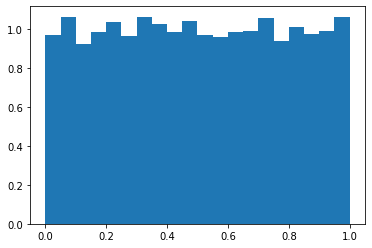

In [6]:
### chi-square heterogeneity test
def hetero_test(effects, se):
    effects = np.array(effects, dtype=np.float32)
    se = np.array(se, dtype=np.float32)
    wt = 1.0 / (se**2)
    effects_mean = wt.dot(effects) / wt.sum()
    chi_square = ((effects - effects_mean)**2 / (se**2)).sum()
    df = len(effects) - 1
    p_val = 1 - sp.stats.chi2.cdf(chi_square, df)
    # other stats 
    var_within = (se**2).mean()
    n_group = len(effects)
    var_between = ((effects - np.mean(effects))**2).sum() / n_group
    var_between = var_between - (se**2).sum() * (n_group-1) / n_group**2
    var_ratio = var_between / var_within
    return chi_square,p_val,var_within,var_between,var_ratio
    
v_mean = np.array([1, 1, 1, 1])
v_se = np.array([1, 2, 1, 1])
n_sample = v_mean.shape[0]

p_list = []
var_within_list = []
var_between_list = []
for i in range(10000):
    np.random.seed(i)
    v_x = np.random.randn(n_sample) * v_se + v_mean
    chi_square,p_val,var_within,var_between,var_ratio = hetero_test(v_x, v_se)
    p_list.append(p_val)
    var_within_list.append(var_within)
    var_between_list.append(var_between)

print('var_between', np.mean(var_between_list))
plt.figure()
plt.hist(p_list, density=True, bins=20)
plt.show()

In [7]:
# heterogeneity test across traits
res,term = 'omega','cor'
md = 'md_prox_gene_fct_all_ld'
df_plot = pd.DataFrame(
    index = dic_res[md][TRAIT_LIST_INDPT[0]]['summary'][res].index, 
    columns = ['chi_square', 'p', 'var_within', 'var_between', 'var_ratio', 'fwer', 'fdr'], dtype=float,
)

for row in df_plot.index:
    v_mean = [dic_res[md][x]['summary']['omega'].loc[row, term] for x in TRAIT_LIST_INDPT]
    v_se = [dic_res[md][x]['summary']['omega'].loc[row, '%s_se' % term] for x in TRAIT_LIST_INDPT]
    chi_square,p_val,var_within,var_between,var_ratio = hetero_test(v_mean, v_se)
    df_plot.loc[row, ['chi_square', 'p', 'var_within', 'var_between', 'var_ratio']] = \
        chi_square,p_val,var_within,var_between,var_ratio
df_plot['fwer'] = df_plot['p'] * df_plot.shape[0]
df_plot['fdr'] = multipletests(df_plot['p'], method='fdr_bh')[1]
df_plot.to_csv(TAB_PATH+'/hetero.tsv', sep='\t')
display(df_plot.loc[df_plot['fwer']<0.05])
display(df_plot.loc[df_plot['fdr']<0.3])
print('median variance ratio = %0.3f' % df_plot['var_ratio'].median())
temp_list = [x for x in df_plot.index if x.startswith('pAN:proxy_')]
print('Prox: median variance ratio = %0.3f' % df_plot.loc[temp_list, 'var_ratio'].median())

,chi_square,p,var_within,var_between,var_ratio,fwer,fdr
pAN:Repressed_Hoffman_proxy_0_1000_ld_p0_p100_maf_lf_block,60.54578,0.000347,0.399824,0.333966,0.835283,0.047154,0.047154


,chi_square,p,var_within,var_between,var_ratio,fwer,fdr
pAN:proxy_1000_10000_ld_n100_p0_maf_lf_block,50.651119,0.005466,0.003362,0.002964,0.881420,0.743401,0.247800
pAN:Repressed_Hoffman_proxy_0_100_ld_p0_p100_maf_common_block,49.441418,0.007460,0.514866,0.248842,0.483315,1.014626,0.253656
pAN:Repressed_Hoffman_proxy_0_1000_ld_p0_p100_maf_lf_block,60.545780,0.000347,0.399824,0.333966,0.835283,0.047154,0.047154
pAN:Repressed_Hoffman_proxy_0_1000_ld_n100_p0_maf_lf_block,52.560020,0.003304,0.424006,0.599191,1.413165,0.449368,0.224684


median variance ratio = 0.041
Prox: median variance ratio = 0.173
